<a href="https://colab.research.google.com/github/Michal287/computer_vision/blob/main/MultiLabelClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.11 torchvision==0.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
# Os
from google.colab import drive
import os
import random

# Plots
import matplotlib.pyplot as plt

# OpenCV
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
from tqdm import tqdm

import torch

# Sprawdzenie czy pyTorch widzi GPU

In [ ]:
import torch

# Sprawdź, czy CUDA jest dostępny
if torch.cuda.is_available():
    # Wyświetl informacje o dostępnym urządzeniu CUDA
    print("CUDA jest dostępne.")
    device = torch.cuda.current_device()
    print(f"Obecne urządzenie CUDA: {torch.cuda.get_device_name(device)}")
    print(f"Wersja CUDA: {torch.version.cuda}")
else:
    print("CUDA nie jest dostępna.")


CUDA jest dostępne.
Obecne urządzenie CUDA: Tesla T4
Wersja CUDA: 10.2


# Podłączenie do dysku google

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pobieranie danych

In [ ]:
!7z x /content/drive/MyDrive/stab_multilabel_data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 166447246 bytes (159 MiB)

Extracting archive: /content/drive/MyDrive/stab_multilabel_data.zip
--
Path = /content/drive/MyDrive/stab_multilabel_data.zip
Type = zip
Physical Size = 166447246

  0%      1% 40 - stab_multilabel_data/group_1/image_1144.png                                                       3% 85 - stab_multilabel_data/group_1/image_1336.png                                                     

# Sprawdzanie danych

In [ ]:
folder_name = "data"

folders = sorted(os.listdir(folder_name))
image_dict = {}

for folder in folders:
    image_dict[folder] = os.listdir(f"{folder_name}/{folder}")

In [ ]:
def show_samples(paths):
    samples = len(paths)
    plt.figure(figsize=(5*3, samples*3))

    for idx, (group, image_paths) in enumerate(paths.items()):
        image = cv2.imread(f"{folder_name}/{group}/{random.choice(image_paths)}")

        plt.subplot(samples, 3, idx+1)
        plt.title(group)
        plt.imshow(image)

    plt.savefig('samples.png')

show_samples(image_dict)

In [ ]:
classes = ["niezahartowany", "brak_wielowypustu", "brak_kanalka", "srodek_nieobrobiony"]

label_mapping = {
      "group_1": ["niezahartowany", "brak_wielowypustu", "brak_kanalka"],
      "group_2": ["niezahartowany", "brak_kanalka"],
      "group_3": ["brak_wielowypustu", "brak_kanalka", "srodek_nieobrobiony"],
      "group_4": ["brak_wielowypustu", "srodek_nieobrobiony"],
      "group_5": ["brak_kanalka", "srodek_nieobrobiony"],
      "group_6": ["srodek_nieobrobiony"],
      "group_7": [],
      "group_8": ["brak_kanalka"],
      "group_9": ["brak_wielowypustu"],
  }

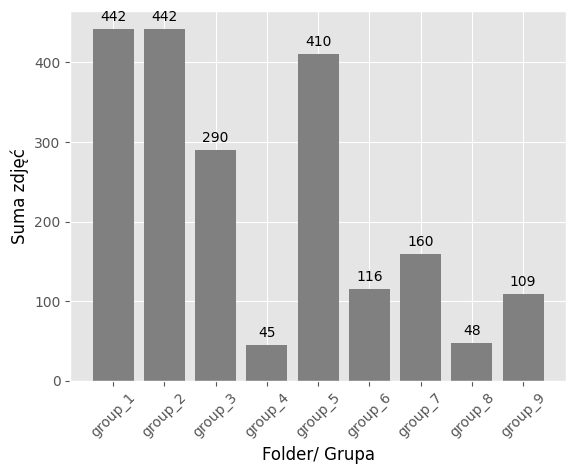

In [ ]:
sum_images = [len(image_paths) for image_paths in image_dict.values()]

plt.style.use("ggplot")
plt.bar(image_dict.keys(), sum_images, label="Sum images of classes", color="gray")
plt.plot()

plt.xticks(rotation=45)
plt.xlabel("Folder/ Grupa", color="black")
plt.ylabel("Suma zdjęć", color="black")

for i, value in enumerate(sum_images):
    plt.text(i, value + 10, str(value), ha="center", color="black")

plt.show()

In [ ]:
classes_summary = {k: 0 for k in classes}

for group, image_paths in image_dict.items():
    classes_group = label_mapping[group]

    for key in classes_summary:
        if key in classes_group:
            classes_summary[key] += len(image_paths)

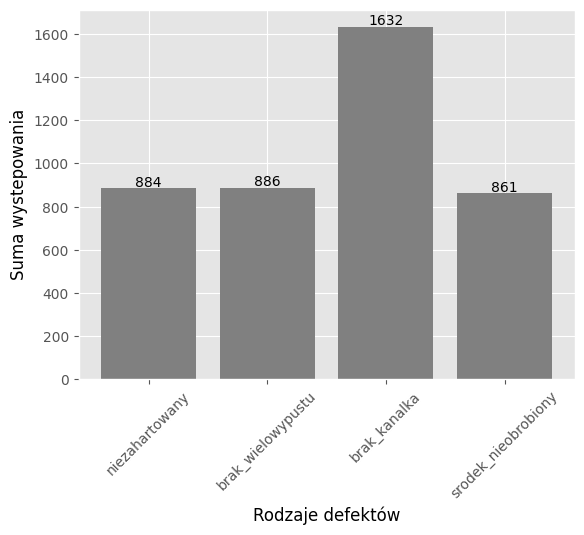

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.style.use("ggplot")
plt.bar(classes_summary.keys(), classes_summary.values(), label="Sum images of classes", color="gray")
plt.plot()

plt.xticks(rotation=45)
plt.xlabel("Rodzaje defektów", color="black")
plt.ylabel("Suma wystepowania", color="black")

for i, value in enumerate(classes_summary.values()):
    plt.text(i, value + 10, str(value), ha="center", color="black")

plt.show()
plt.savefig('sum_of_defects.png')

# Ładowanie danych

In [ ]:
def oneHotEncoder(labels):
    return [1 if c in labels else 0 for c in classes]

def get_data(startpath):
    image_list = []
    label_list = []

    for root, dirs, files in os.walk(startpath):
        for file in files:
            dir_name = root.split("/")[1]
            label_list.append(label_mapping[dir_name])
            image_list.append(os.path.join(root, file))

    label_list = [oneHotEncoder(label) for label in label_list]

    return image_list, np.array(label_list)

image_list, labels = get_data('data')

In [ ]:
print(f"Image path: {image_list[0]}, Label: {labels[0]}")

Image path: data/group_5/image_669.png, Label: [0 0 1 1]


# Check image size

In [ ]:
height = []
width = []

for img_path in image_list:
    img = cv2.imread(img_path)
    height.append(img.shape[0])
    width.append(img.shape[1])

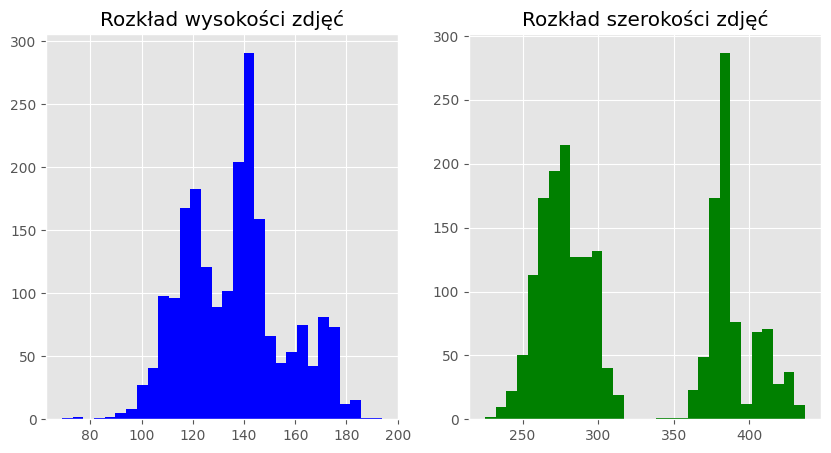

In [ ]:
height = sorted(height)
width = sorted(width)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(height, bins=30, color='blue')
axs[0].set_title('Rozkład wysokości zdjęć')

axs[1].hist(width, bins=30, color='green')
axs[1].set_title('Rozkład szerokości zdjęć')

# wyświetlenie subplotu
plt.show()

# Ładowanie danych

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_list, labels, test_size=0.2, stratify=labels, shuffle=True)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
class ImageDataset(Dataset):
    def __init__(self, image_list, label_list, prepocessing=None, transforms=None):
        self.image_list = image_list
        self.label_list = label_list
        self.prepocessing = prepocessing
        self.transforms = transforms

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Pobierz etykietę na podstawie indeksu idx
        label = self.label_list[idx]

        # Zastosuj transformacje, jeśli są dostępne
        if self.transforms is not None:
            data = {"image": image}
            augmented = self.transforms(**data)
            image = augmented["image"]

        image = self.prepocessing(image)

        return image, label

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import Grayscale, Compose, ToPILImage, Grayscale, Resize, ToTensor

def augmentation():
    return A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.15, p=0.2),
        A.Blur(blur_limit=2, p=0.2),
        A.HorizontalFlip(p=0.2),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=15, border_mode=1, p=0.2),
    ])


def preprocessing(image):
    transform = Compose([
        ToPILImage(),
        #Grayscale(num_output_channels=1),
        Resize((128, 128)),
        ToTensor(),
    ])
    preprocessed_image = transform(image)
    return preprocessed_image


train_dataset = ImageDataset(X_train, y_train, preprocessing, augmentation())
val_dataset = ImageDataset(X_val, y_val, preprocessing)

batch_size = 16

train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

from torchvision.models.resnet import resnet18

class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = resnet18(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

# Initialize the model
model = Resnet18(4)
model.to(device)
# Switch model to the training mode
model.train()
summary(model, (3, 128, 128))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score

# Definicja modelu i inne przygotowania...

# Przygotowanie optymalizatora i kryterium
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.002)  # Optymalizator Adam

best_loss = float('inf')  # Najlepszy wynik straty (inicjalizowany na wartość nieskończoną)
best_accuracy = 0.0  # Najlepsza dokładność (inicjalizowana na 0)
best_recall = 0.0  # Najlepszy recall (inicjalizowany na 0)

# Przetrenowanie modelu
num_epochs = 300  # Liczba epok treningowych (zmień na odpowiednią wartość)

for epoch in range(num_epochs):
    model.train()  # Przełącz na tryb treningowy
    running_train_loss = 0.0
    true_train_labels = []
    predicted_train_labels = []

    for inputs, labels in train_dataset_loader:
        optimizer.zero_grad()  # Zeruj gradienty

        inputs = inputs.to(device).float()  # Przekształć dane wejściowe na GPU
        labels = labels.to(device).float()

        outputs = model(inputs)  # Forward pass
        train_loss = criterion(outputs, labels)  # Obliczenie straty
        train_loss.backward()  # Backpropagation
        optimizer.step()  # Aktualizacja wag

        running_train_loss += train_loss.item()

        # Konwertuj wyniki modelu na etykiety binarne (np. na podstawie progu 0.5)
        predicted_train_labels += [(output > 0.5).float().cpu().numpy() for output in outputs]
        true_train_labels += labels.cpu().numpy().tolist()

    # Oblicz metryki accuracy i recall dla treningu
    true_train_labels = np.array(true_train_labels)
    predicted_train_labels = np.array(predicted_train_labels)

    # Oblicz metryki accuracy i recall dla treningu
    train_accuracy = accuracy_score(true_train_labels, predicted_train_labels)
    train_recall = recall_score(true_train_labels, predicted_train_labels, average='macro')

    # Wyświetl bieżący stan treningu i metryki treningowe w jednej linii
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training Loss: {round(running_train_loss / len(train_dataset_loader), 4)} - Training Accuracy: {round(train_accuracy, 4)} - Training Recall: {round(train_recall, 4)}')

    # Walidacja modelu (przy założeniu, że masz oddzielny DataLoader dla walidacji)
    model.eval()  # Przełącz na tryb ewaluacji
    running_val_loss = 0.0
    true_val_labels = []
    predicted_val_labels = []

    for inputs, labels in val_dataset_loader:
        inputs = inputs.to(device).float()  # Przekształć dane wejściowe na GPU
        labels = labels.to(device).float()

        outputs = model(inputs)  # Forward pass
        val_loss = criterion(outputs, labels)  # Obliczenie straty

        running_val_loss += val_loss.item()

        # Konwertuj wyniki modelu na etykiety binarne (np. na podstawie progu 0.5)
        predicted_val_labels += [(output > 0.5).float().cpu().numpy() for output in outputs]
        true_val_labels += labels.cpu().numpy().tolist()

    # Przekształć listy etykiet na tablice NumPy
    true_val_labels = np.array(true_val_labels)
    predicted_val_labels = np.array(predicted_val_labels)

    # Oblicz metryki accuracy i recall dla walidacji
    val_accuracy = accuracy_score(true_val_labels, predicted_val_labels)
    val_recall = recall_score(true_val_labels, predicted_val_labels, average='macro')

    runngin_val_loss_con = running_val_loss / len(val_dataset_loader)

    # Wyświetl bieżący stan walidacji i metryki walidacyjne w jednej linii
    print(f'Validation Loss: {round(runngin_val_loss_con, 4)} - Validation Accuracy: {round(val_accuracy, 4)} - Validation Recall: {round(val_recall, 4)}')


    if runngin_val_loss_con <= best_loss:
        best_loss = runngin_val_loss_con
        # Zapisz model
        torch.save(model.state_dict(), f'model_val_loss.pth')

    if val_accuracy >= best_accuracy:
        best_accuracy = val_accuracy
        # Zapisz model
        torch.save(model.state_dict(), f'model_val_accuracy.pth')

    if val_recall >= best_recall:
        best_recall = val_recall
        # Zapisz model
        torch.save(model.state_dict(), f'model_val_recall_.pth')

print('Trening zakończony.')

Epoch [1/300]
Training Loss: 0.241 - Training Accuracy: 0.6756 - Training Recall: 0.9089
Validation Loss: 0.1514 - Validation Accuracy: 0.7869 - Validation Recall: 0.9924
Epoch [2/300]
Training Loss: 0.1549 - Training Accuracy: 0.7956 - Training Recall: 0.9587
Validation Loss: 0.5415 - Validation Accuracy: 0.5206 - Validation Recall: 0.9216
Epoch [3/300]
Training Loss: 0.1018 - Training Accuracy: 0.8642 - Training Recall: 0.9724
Validation Loss: 0.0837 - Validation Accuracy: 0.8838 - Validation Recall: 0.9835
Epoch [4/300]
Training Loss: 0.0969 - Training Accuracy: 0.8896 - Training Recall: 0.9775
Validation Loss: 0.3502 - Validation Accuracy: 0.6949 - Validation Recall: 0.9794
Epoch [5/300]
Training Loss: 0.0901 - Training Accuracy: 0.8793 - Training Recall: 0.9735
Validation Loss: 0.0407 - Validation Accuracy: 0.9419 - Validation Recall: 0.9917
Epoch [6/300]
Training Loss: 0.0595 - Training Accuracy: 0.9212 - Training Recall: 0.9863
Validation Loss: 0.0475 - Validation Accuracy: 0.91

KeyboardInterrupt: ignored

In [ ]:
# model = Classifier()
# model.load_state_dict(torch.load('model_val_accuracy2.pth'))
# model.to(device)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_images(dataloader, num_images, figsize=(15, 15)):
    # Pobieramy batch z dataloader
    images, targets = list(dataloader)[2]

    # Wybieramy pierwsze `num_images` obrazów i targety
    images = images[:num_images]
    targets = targets[:num_images]

    # Obliczamy liczbę rzędów potrzebnych do wyświetlenia obrazów w 3 kolumnach
    num_rows = int(np.ceil(num_images / 3))

    fig = plt.figure(figsize=figsize)

    for i in range(num_images):
        ax = fig.add_subplot(num_rows, 3, i+1)

        img = images[i].to(device).float()
        img = img.unsqueeze(0)
        print(img.shape)

        # Przekształcamy obraz z tensora do formatu PIL i następnie do ndarray dla wyświetlenia w matplotlib
        with torch.no_grad():
            prediction = model(img)[0]

        output = [classes[i] for i in range(len(classes)) if prediction[i] > 0.5]

        ax.text(0, -20, f"Results: {', '.join(output)}", fontsize=12, color='white', backgroundcolor='black')
        # Rysujemy obraz
        data_permuted = img.squeeze().permute(1, 2, 0)
        img = data_permuted.cpu().numpy()

        ax.imshow(img, cmap='gray')

        # Wyłączamy wyświetlanie osi
        plt.axis('off')

    plt.tight_layout()
    plt.show()

model.eval()
show_images(train_dataset_loader, 9)

In [ ]:
torch.save(model.state_dict(), f'test2.pth')